## Lets start by reading every text file in the directory subfolders and store the words in the texts under the subfolders labels

In [216]:

import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import os
import glob
import re
import math
from sklearn.feature_extraction.text import CountVectorizer

parent_folder = 'bbc'
subfolders = ['business', 'entertainment', 'sport', 'politics', 'tech']
word_dict = defaultdict(list)
categories_count = defaultdict(int)
all_words = []

total_samples = 0

def tokenize_text(text):
    words = text.lower().split()
    words = [re.sub(r"[^a-zA-Z0-9]", "", word) for word in words]
    stop_words = set(['the', 'is', 'are', 'and', 'that', 'do', 'have'])
    words = [word for word in words if word not in stop_words]
    words = [word[:-1] if word.endswith('s') else word for word in words]
    return words

for subfolder in subfolders:
    folder_path = os.path.join(parent_folder, subfolder)
    files = glob.glob(os.path.join(folder_path, '*.txt'))

    categories_count[subfolder] += len(files)
    total_samples += len(files)

    for file_path in files[:300]:
        with open(file_path, 'r') as file:
            content = file.read()
            words = tokenize_text(content)

            for word in words:
                all_words.append(word)
                if word not in word_dict:
                    word_dict[subfolder].append(word)
                else:
                    if subfolder not in word_dict[word]:
                        word_dict[word].append(subfolder)







## Next, lets caclulate the probability of a word given the label it's under

In [217]:

word_given_business = defaultdict(float)
word_given_sport = defaultdict(float)
word_given_entertainment = defaultdict(float)
word_given_tech = defaultdict(float)
word_given_politics = defaultdict(float)
counter_business = Counter(word_dict['business'])
counter_sport = Counter(word_dict['sport'])
counter_entertainment = Counter(word_dict['entertainment'])
counter_tech = Counter(word_dict['tech'])
counter_politics = Counter(word_dict['politics'])

for word in word_dict['business']:
    word_given_business[word] = (counter_business[word] + 1) / (categories_count['business'] + len(word_dict['business']))
for word in word_dict['sport']:
    word_given_sport[word] = (counter_sport[word] + 1) / (categories_count['sport'] + len(word_dict['sport']))
for word in word_dict['entertainment']:
    word_given_entertainment[word] = (counter_entertainment[word] + 1) / (categories_count['entertainment'] + len(word_dict['entertainment']))
for word in word_dict['politics']:
    word_given_politics[word] = (counter_politics[word] + 1) / (categories_count['politics'] + len(word_dict['politics']))
for word in word_dict['tech']:
    word_given_tech[word] = (counter_tech[word] + 1) / (categories_count['tech'] + len(word_dict['tech']))

## Next up, we calculate the probability of each word relative to the whole dataset we have.

In [218]:
probabiltiy_of_word = defaultdict(float)
words_count = Counter(all_words)

for word in words_count:
    probabiltiy_of_word[word] = words_count[word] / len(all_words)

## Let's store the probabilities of each label

In [219]:

probability_of_business = categories_count['business'] / total_samples
probability_of_sport = categories_count['sport'] / total_samples
probability_of_entertainment = categories_count['entertainment'] / total_samples
probability_of_tech = categories_count['tech'] / total_samples
probability_of_politics = categories_count['politics'] / total_samples

## Now that we have everything we need to make predictions for some unseen data, let's proceed to build a function that will predict label given the text of a news article

In [220]:
def classifier(words, k):
    labels = ['business', 'entertainment', 'sport', 'politics', 'tech']
    probability_of_label = defaultdict(float)
    probability_of_label['business'] = math.log(probability_of_business)
    probability_of_label['entertainment'] = math.log(probability_of_entertainment)
    probability_of_label['sport'] = math.log(probability_of_sport)
    probability_of_label['politics'] = math.log(probability_of_politics)
    probability_of_label['tech'] = math.log(probability_of_tech)

    for word in words:
        if word in word_given_business:
            probability_of_label['business'] += math.log(word_given_business[word])
        else:
            probability_of_label['business'] += math.log(k / (categories_count['business'] + len(word_dict['business']) * k))

        if word in word_given_entertainment:
            probability_of_label['entertainment'] += math.log(word_given_entertainment[word])
        else:
            probability_of_label['entertainment'] += math.log(k / (categories_count['entertainment'] + len(word_dict['entertainment']) * k))

        if word in word_given_sport:
            probability_of_label['sport'] += math.log(word_given_sport[word])
        else:
            probability_of_label['sport'] += math.log(k / (categories_count['sport'] + len(word_dict['sport']) * k))

        if word in word_given_politics:
            probability_of_label['politics'] += math.log(word_given_politics[word])
        else:
            probability_of_label['politics'] += math.log(k / (categories_count['politics'] + len(word_dict['politics']) * k))

        if word in word_given_tech:
            probability_of_label['tech'] += math.log(word_given_tech[word])
        else:
            probability_of_label['tech'] += math.log(k / (categories_count['tech'] + len(word_dict['tech']) * k))

    predicted_label = max(probability_of_label, key=probability_of_label.get)
    return predicted_label




# Now that we have trained our model and wrote a test function, lets test it with datas.

Accuracy for k = 0.1 : 0.9710344827586207
Accuracy for k = 0.5 : 0.48482758620689653
Accuracy for k = 1.0 : 0.3232183908045977
Accuracy for k = 10 : 0.24241379310344827
Accuracy for k = 100 : 0.1939310344827586


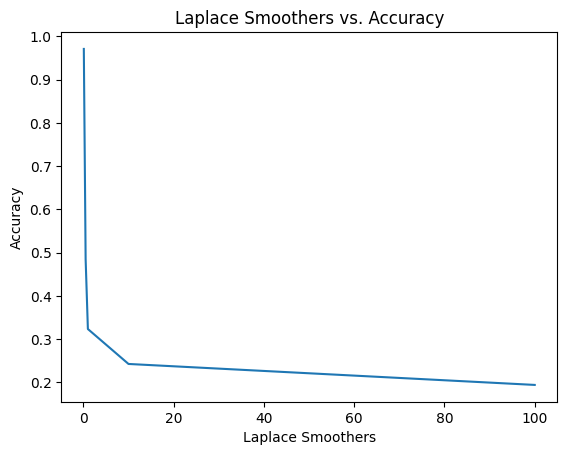

In [222]:
laplace_smoothers = [0.1, 0.5, 1.0, 10, 100]
accuracy = []
samples =0
for k in laplace_smoothers:
    corrects = 0
    for subfolder in subfolders:
        folder_path = os.path.join(parent_folder, subfolder)
        files = glob.glob(os.path.join(folder_path, '*.txt'))
        for file_path in files[300:]:
            samples = samples + 1
            with open(file_path, 'r') as file:
                content = file.read()
                words = tokenize_text(content)
                if subfolder == classifier(words, k):
                    corrects += 1
    accuracy.append(corrects / samples)
    print("Accuracy for k =", k, ":", corrects / samples)
plt.plot(laplace_smoothers, accuracy)
plt.xlabel('Laplace Smoothers')
plt.ylabel('Accuracy')
plt.title('Laplace Smoothers vs. Accuracy')
plt.show()